## ABC

In [1]:
import sys
import os

# Add the parent directory (sbi) to sys.path
sys.path.insert(0, os.path.abspath('..'))

# Now try importing your local sbi package
import sbi
import sbi.simulators
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

#print("sbi package imported successfully")


2024-12-09 16:40:15.442 | INFO     | sbi.config:<module>:11 - PROJ_ROOT path is: C:\Users\Theodora\Documents\master2\sbi


In [2]:
np.random.seed(7)

In [3]:
linear_sim = sbi.simulators.LinearSimulator(sigma_noise=0.1)
uniform_prior = sbi.simulators.UniformPrior(-2, 2, dim=2)

In [4]:
x_obs = np.random.normal(size=(2,))
print(f"X fixed value is: {x_obs}")
y_obs = np.array(0.3)

X fixed value is: [ 1.6905257  -0.46593737]


In [5]:
import sbi.models.abc
abc_inference1 = sbi.models.abc.ABCInference(x=x_obs, obs=y_obs)
samples_pos1 = abc_inference1.infer(target_samples=100, Nsamples=10000, simulator_func=linear_sim.simulate_numpy, prior=uniform_prior.sample_numpy)
abc_inference2 = sbi.models.abc.ABCInference(x=x_obs, obs=y_obs, eps=0.05)
samples_pos2 = abc_inference2.infer(target_samples=100, Nsamples=10000, batch_size=100, simulator_func=linear_sim.simulate_numpy, prior=uniform_prior.sample_numpy)


The final step is: 7600


In [6]:
print (f" The number of posterior samples 1 is : {samples_pos1.shape[0]}\n")
print(f"The mean value of posterior 1 is : {samples_pos1.mean(axis=0)}\n")
print(f"The standard deviation of posterior 1 is : {samples_pos1.std(axis=0)}")

print("--"*50)
print(f"The number of posterior samples 2 is : {samples_pos2.shape[0]}\n")
print(f"The mean value of posterior 2 is : {samples_pos2.mean(axis=0)}\n")
print(f"The standard deviation of posterior 2 is : {samples_pos2.std(axis=0)}")

 The number of posterior samples 1 is : 100

The mean value of posterior 1 is : [ 0.0080046  -0.18434891]

The standard deviation of posterior 1 is : [0.30700174 1.1106974 ]
----------------------------------------------------------------------------------------------------
The number of posterior samples 2 is : 100

The mean value of posterior 2 is : [ 0.15002185 -0.14426199]

The standard deviation of posterior 2 is : [0.31107616 1.1569337 ]


In [7]:
print(samples_pos2.min(axis=0))
print(samples_pos2.max(axis=0))

[-0.37534964 -1.9923075 ]
[0.75693727 1.9098008 ]


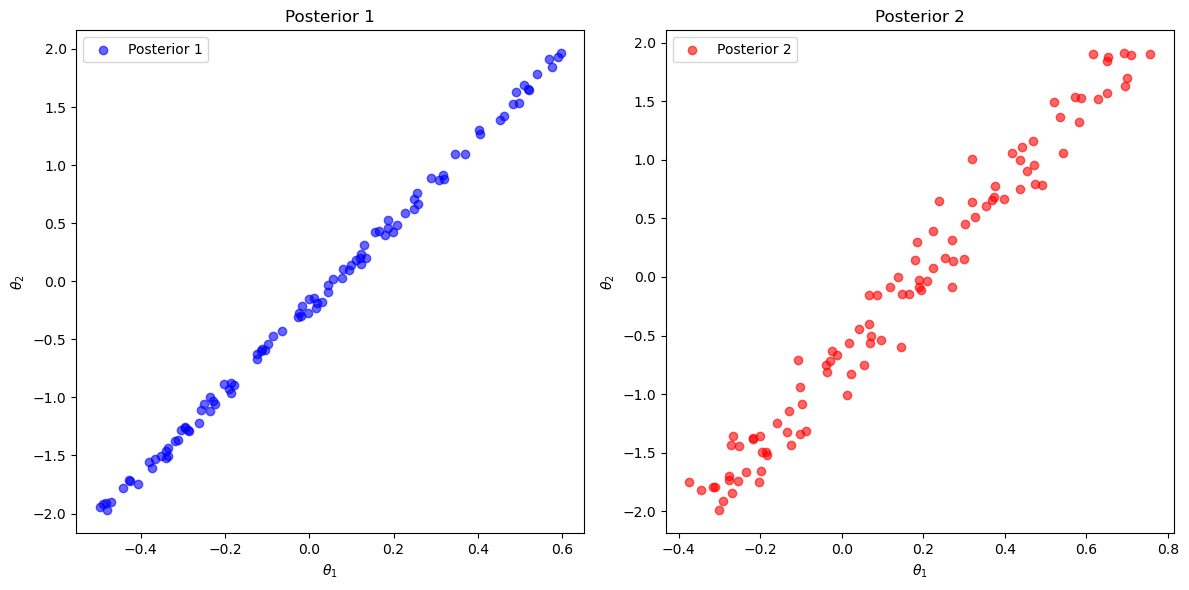

In [8]:
# Plot figures
import matplotlib.pyplot as plt

# Plot figures
fig, axes = plt.subplots(1,2, figsize=(12,6)) 

# Scatter plots for the posteriors from abc_methods
axes[0].scatter(samples_pos1[:,0], samples_pos1[:,1], alpha = 0.6, color='blue', label='Posterior 1')
axes[0].set_title('Posterior 1')
axes[0].set_xlabel(r"$\theta_1$")
axes[0].set_ylabel(r"$\theta_2$")
axes[0].legend()

axes[1].scatter(samples_pos2[:, 0], samples_pos2[:, 1], alpha = 0.6, color='red', label='Posterior 2')
axes[1].set_title('Posterior 2')
axes[1].set_xlabel(r"$\theta_1$")
axes[1].set_ylabel(r"$\theta_2$")
axes[1].legend()

plt.tight_layout()
plt.show()

In [9]:
key = random.PRNGKey(42)
samples_pos1_jax = abc_inference1.infer(target_samples=100, Nsamples=10000, simulator_func=linear_sim.simulate_jax, prior=uniform_prior.sample_jax, key=key)
samples_pos2_jax = abc_inference2.infer(target_samples=100, Nsamples=10000, batch_size=100, simulator_func = linear_sim.simulate_jax, prior=uniform_prior.sample_jax, key=key)


The final step is: 6600


In [10]:
print (f" The number of posterior samples 1 is : {samples_pos1_jax.shape[0]}\n")
print(f"The mean value of posterior 1 is : {samples_pos1_jax.mean(axis=0)}\n")
print(f"The standard deviation of posterior 1 is : {samples_pos1_jax.std(axis=0)}")

print("--"*50)
print(f"The number of posterior samples 2 is : {samples_pos2_jax.shape[0]}\n")
print(f"The mean value of posterior 2 is : {samples_pos2_jax.mean(axis=0)}\n")
print(f"The standard deviation of posterior 2 is : {samples_pos2_jax.std(axis=0)}")

 The number of posterior samples 1 is : 100

The mean value of posterior 1 is : [0.18163593 0.04634067]

The standard deviation of posterior 1 is : [0.32994577 1.1926486 ]
----------------------------------------------------------------------------------------------------
The number of posterior samples 2 is : 100

The mean value of posterior 2 is : [0.19420952 0.04666616]

The standard deviation of posterior 2 is : [0.3141789 1.1436533]


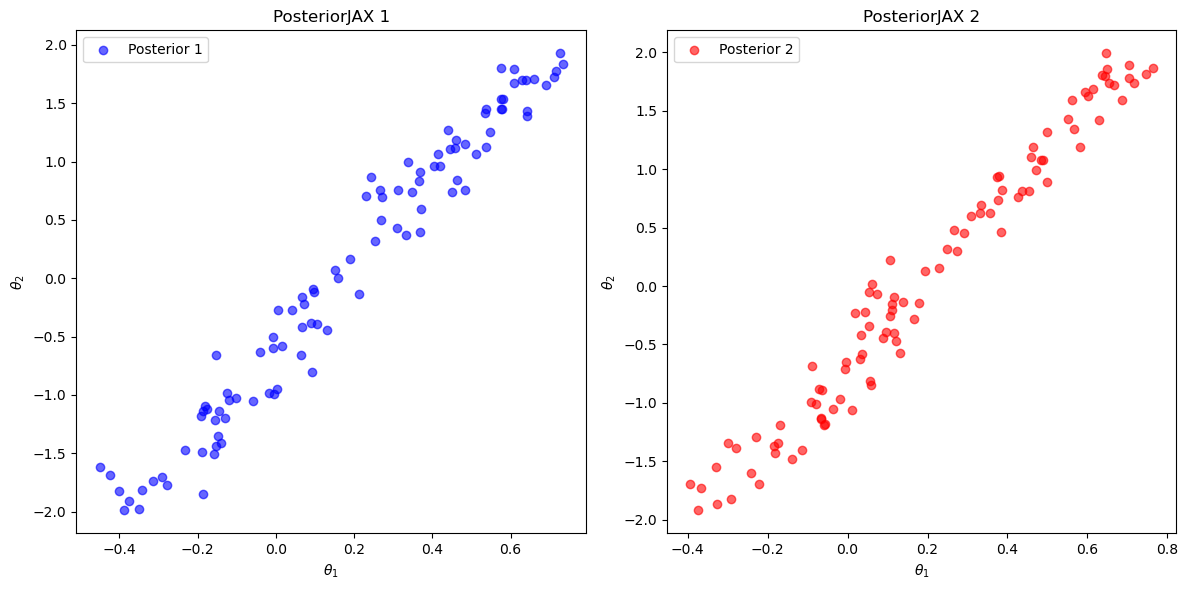

In [11]:
# Plot figures
import matplotlib.pyplot as plt

# Plot figures
fig, axes = plt.subplots(1,2, figsize=(12,6)) 

# Scatter plots for the posteriors from abc_methods
axes[0].scatter(samples_pos1_jax[:,0], samples_pos1_jax[:,1], alpha = 0.6, color='blue', label='Posterior 1')
axes[0].set_title('PosteriorJAX 1')
axes[0].set_xlabel(r"$\theta_1$")
axes[0].set_ylabel(r"$\theta_2$")
axes[0].legend()

axes[1].scatter(samples_pos2_jax[:, 0], samples_pos2_jax[:, 1], alpha = 0.6, color='red', label='Posterior 2')
axes[1].set_title('PosteriorJAX 2')
axes[1].set_xlabel(r"$\theta_1$")
axes[1].set_ylabel(r"$\theta_2$")
axes[1].legend()

plt.tight_layout()
plt.show()


## SMC

In [12]:
import sbi.models.smc

In [13]:
tolerance_sequence=[0.1, 0.05, 0.01] 

abc_inference_smc = sbi.models.smc.SMC(x=x_obs, obs=y_obs)
results = abc_inference_smc.smc_algorithm(tolerance_sequence = tolerance_sequence,
                                                 target_samples = 100,
                                                 Nsamples = 10_000,
                                                 prior = uniform_prior.sample_numpy,
                                                 simulator_func = linear_sim.simulate_numpy)

Starting SMC for epsilon: 0.1
Running SMC for epsilon=0.05
Running SMC for epsilon=0.01


In [14]:
print(f"Eps: {results[0]['epsilon']} - Mean Pos Value: {results[0]['samples_pos'].mean(axis=0)} - STD: {results[0]['samples_pos'].std(axis=0)}")
print(f"Eps: {results[1]['epsilon']} - Mean Pos Value: {results[1]['samples_pos'].mean(axis=0)} - STD: {results[1]['samples_pos'].std(axis=0)}")
print(f"Eps: {results[2]['epsilon']} - Mean Pos Value: {results[2]['samples_pos'].mean(axis=0)} - STD: {results[2]['samples_pos'].std(axis=0)}")

Eps: 0.1 - Mean Pos Value: [ 0.24495362 -0.02480417] - STD: [0.31179616 1.1167263 ]
Eps: 0.05 - Mean Pos Value: [0.26297998 0.2968595 ] - STD: [0.31359008 1.1244583 ]
Eps: 0.01 - Mean Pos Value: [ 0.11323401 -0.09810676] - STD: [0.300363  1.0911958]


In [15]:
print(len(results[2]['samples_pos']))

100


In [16]:
print(results[2]['samples_pos'].min(axis = 0))
print(results[2]['samples_pos'].max(axis = 0))

[-0.42661497 -2.0428288 ]
[0.65986544 1.896301  ]


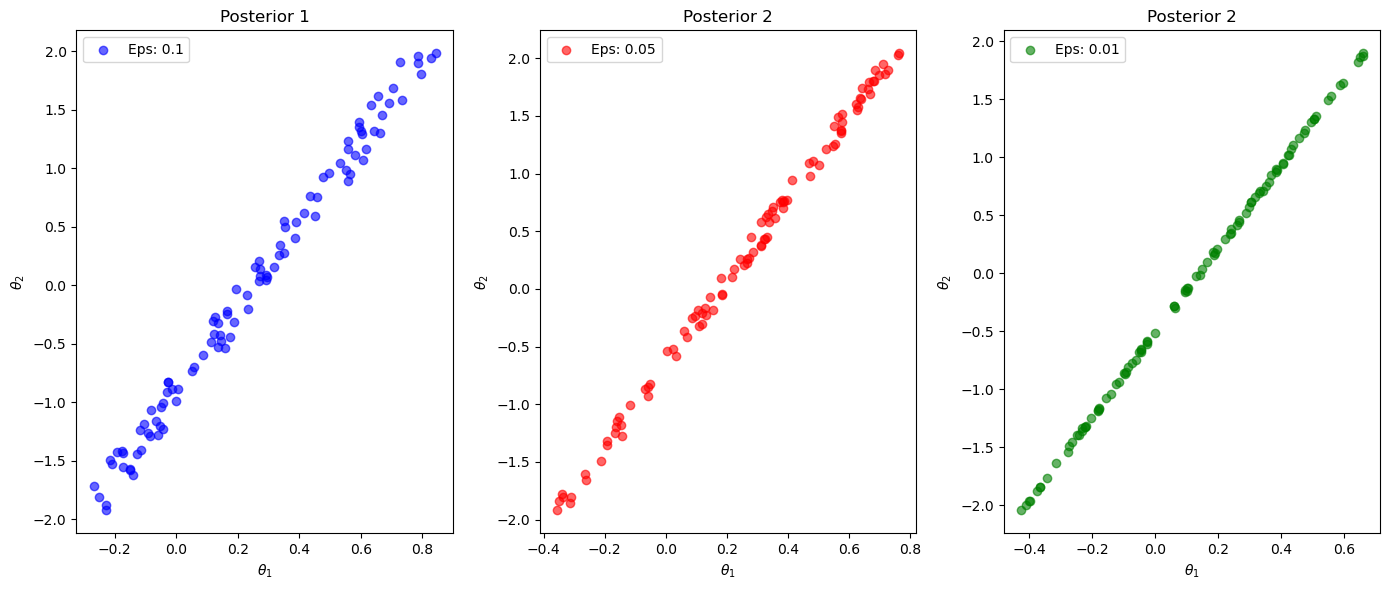

In [17]:
# Plot figures
import matplotlib.pyplot as plt

# Plot figures
fig, axes = plt.subplots(1,3, figsize=(14,6)) 

# Scatter plots for the posteriors from abc_methods
axes[0].scatter(results[0]['samples_pos'][:,0], results[0]['samples_pos'][:,1], alpha = 0.6, color='blue', label=f"Eps: {results[0]['epsilon']}")
axes[0].set_title('Posterior 1')
axes[0].set_xlabel(r"$\theta_1$")
axes[0].set_ylabel(r"$\theta_2$")
axes[0].legend()

axes[1].scatter(results[1]['samples_pos'][:,0], results[1]['samples_pos'][:,1], alpha = 0.6, color='red', label=f"Eps: {results[1]['epsilon']}")
axes[1].set_title('Posterior 2')
axes[1].set_xlabel(r"$\theta_1$")
axes[1].set_ylabel(r"$\theta_2$")
axes[1].legend()

axes[2].scatter(results[2]['samples_pos'][:,0], results[2]['samples_pos'][:,1], alpha = 0.6, color='green', label=f"Eps: {results[2]['epsilon']}")
axes[2].set_title('Posterior 2')
axes[2].set_xlabel(r"$\theta_1$")
axes[2].set_ylabel(r"$\theta_2$")
axes[2].legend()

plt.tight_layout()
plt.show()


In [18]:
import sbi.models.smc

In [19]:
key = random.PRNGKey(42)
tolerance_sequence=[0.1, 0.05, 0.01] 

abc_inference_smc_jax = sbi.models.smc.SMC_JAX(x=x_obs, obs=y_obs)
results_jax = abc_inference_smc_jax.smc_algorithm(tolerance_sequence = tolerance_sequence,
                                                 target_samples = 100,
                                                 Nsamples = 10_000,
                                                 prior = uniform_prior.sample_jax,
                                                 simulator_func = linear_sim.simulate_jax,
                                             key=key)

Starting SMC for epsilon: 0.1
Running SMC for epsilon=0.05
Running SMC for epsilon=0.01


In [20]:
print(f"Eps: {results_jax[0]['epsilon']} - Mean Pos Value: {results_jax[0]['samples_pos'].mean(axis=0)} - STD: {results_jax[0]['samples_pos'].std(axis=0)}")
print(f"Eps: {results_jax[1]['epsilon']} - Mean Pos Value: {results_jax[1]['samples_pos'].mean(axis=0)} - STD: {results_jax[1]['samples_pos'].std(axis=0)}")
print(f"Eps: {results_jax[2]['epsilon']} - Mean Pos Value: {results_jax[2]['samples_pos'].mean(axis=0)} - STD: {results_jax[2]['samples_pos'].std(axis=0)}")

Eps: 0.1 - Mean Pos Value: [ 0.17273895 -0.00108949] - STD: [0.2888686 1.0543591]
Eps: 0.05 - Mean Pos Value: [0.18474613 0.04735557] - STD: [0.3174418 1.1534811]
Eps: 0.01 - Mean Pos Value: [ 0.08266161 -0.3432608 ] - STD: [0.33991504 1.2363281 ]


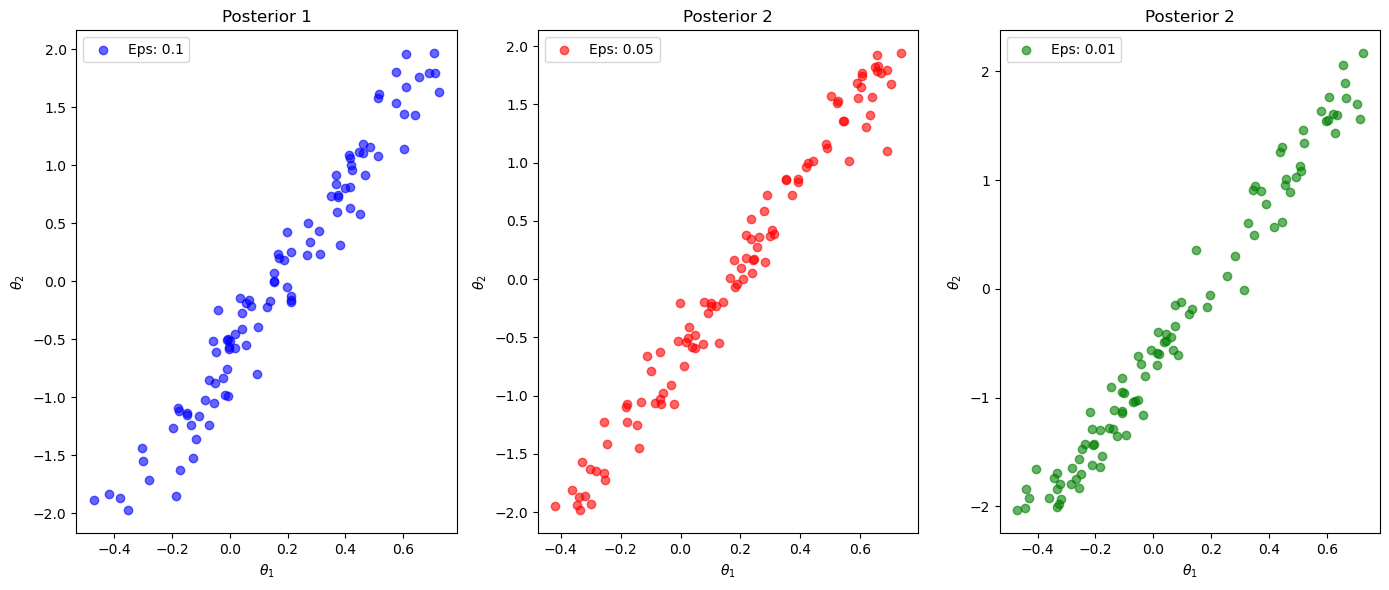

In [21]:
# Plot figures
import matplotlib.pyplot as plt

# Plot figures
fig, axes = plt.subplots(1,3, figsize=(14,6)) 

# Scatter plots for the posteriors from abc_methods
axes[0].scatter(results_jax[0]['samples_pos'][:,0], results_jax[0]['samples_pos'][:,1], alpha = 0.6, color='blue', label=f"Eps: {results[0]['epsilon']}")
axes[0].set_title('Posterior 1')
axes[0].set_xlabel(r"$\theta_1$")
axes[0].set_ylabel(r"$\theta_2$")
axes[0].legend()

axes[1].scatter(results_jax[1]['samples_pos'][:,0], results_jax[1]['samples_pos'][:,1], alpha = 0.6, color='red', label=f"Eps: {results[1]['epsilon']}")
axes[1].set_title('Posterior 2')
axes[1].set_xlabel(r"$\theta_1$")
axes[1].set_ylabel(r"$\theta_2$")
axes[1].legend()

axes[2].scatter(results_jax[2]['samples_pos'][:,0], results_jax[2]['samples_pos'][:,1], alpha = 0.6, color='green', label=f"Eps: {results[2]['epsilon']}")
axes[2].set_title('Posterior 2')
axes[2].set_xlabel(r"$\theta_1$")
axes[2].set_ylabel(r"$\theta_2$")
axes[2].legend()

plt.tight_layout()
plt.show()


In [22]:
print(results_jax[2]['samples_pos'].min(axis = 0))
print(results_jax[2]['samples_pos'].max(axis = 0))

[-0.47119173 -2.0374017 ]
[0.72402155 2.1679265 ]


## ELFI

In [23]:
import sys
import os

# Add the parent directory (sbi) to sys.path
sys.path.insert(0, os.path.abspath('..'))

import elfi
import numpy as np
import sbi
import sbi.simulators
import matplotlib.pyplot as plt
np.random.seed(7)

In [24]:
def simulator_func2(theta1, theta2, x_obs, batch_size=1, random_state=None):
    theta1=np.asarray(theta1).reshape((-1,1))
    theta2=np.asarray(theta2).reshape((-1,1))
    theta = np.hstack((theta1, theta2))
    sigma = np.random.normal(0, 0.1, size=(theta.shape[0],))
    sim = (np.dot(theta, x_obs) + sigma)[:,None]
    print(f"Sim shape: {sim.shape}, ndim: {sim.ndim}")
    return sim

In [25]:
theta_1 = elfi.Prior('uniform', -2, 4)
theta_2 = elfi.Prior('uniform', -2, 4)
x_obs = np.random.normal(size=2)
print(f"X_obs: {x_obs}, shape: {x_obs.shape}")
y_obs = np.array([0.3])[None,:]
print(f"y_obs: {y_obs}, shape: {y_obs.shape}")

sim_data = elfi.Simulator(simulator_func2, theta_1, theta_2, x_obs, observed=y_obs)

X_obs: [ 1.6905257  -0.46593737], shape: (2,)
y_obs: [[0.3]], shape: (1, 1)


In [26]:
d = elfi.Distance('cityblock', sim_data)

In [27]:
rej = elfi.Rejection(d, batch_size=10_000, seed=7)

In [28]:
result = rej.sample(100, quantile=0.01)

Sim shape: (10000, 1), ndim: 2
Progress [==================================================] 100.0% Complete


In [29]:
result

Method: Rejection
Number of samples: 100
Number of simulations: 10000
Threshold: 0.0297
Parameter                Mean               2.5%              97.5%
theta_1:                0.191             -0.330              0.749
theta_2:                0.041             -1.851              1.847


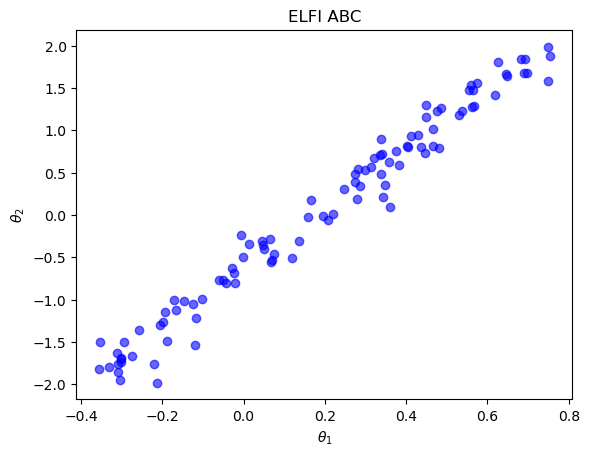

In [30]:
plt.scatter(result.samples['theta_1'], result.samples['theta_2'], alpha=0.6, color='blue')
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.title("ELFI ABC")
plt.show()

In [31]:
smc = elfi.SMC(d, batch_size=10_000, seed=7)

In [32]:
schedule = [0.1, 0.05, 0.01]
%time result_smc=smc.sample(100, schedule)

ABC-SMC Round 1 / 3
Sim shape: (10000, 1), ndim: 2
Progress [==================================================] 100.0% Complete
ABC-SMC Round 2 / 3
Sim shape: (10000, 1), ndim: 2------------------------------] 0.0% Complete
Progress [==================================================] 100.0% Complete
ABC-SMC Round 3 / 3
Sim shape: (10000, 1), ndim: 2------------------------------] 0.0% Complete
Sim shape: (10000, 1), ndim: 2=====-------------------------] 50.0% Complete
Progress [==================================================] 100.0% Complete
CPU times: total: 93.8 ms
Wall time: 96.6 ms


In [33]:
result_smc.summary(all=True)

Method: SMC
Number of samples: 100
Number of simulations: 40000
Threshold: 0.00547
Parameter                Mean               2.5%              97.5%
theta_1:                0.203             -0.407              0.736
theta_2:                0.040             -1.977              1.855


Population 0:
Method: Rejection within SMC-ABC
Number of samples: 100
Number of simulations: 10000
Threshold: 0.0319
Parameter                Mean               2.5%              97.5%
theta_1:                0.230             -0.340              0.692
theta_2:                0.156             -1.802              1.734


Population 1:
Method: Rejection within SMC-ABC
Number of samples: 100
Number of simulations: 10000
Threshold: 0.0116
Parameter                Mean               2.5%              97.5%
theta_1:                0.230             -0.344              0.716
theta_2:                0.203             -1.789              1.944


Population 2:
Method: Rejection within SMC-ABC
Number of samples:

In [34]:
result_smc.sample_means_summary(all=True)

Sample means for population 0: theta_1: 0.23, theta_2: 0.156
Sample means for population 1: theta_1: 0.23, theta_2: 0.203
Sample means for population 2: theta_1: 0.203, theta_2: 0.0399



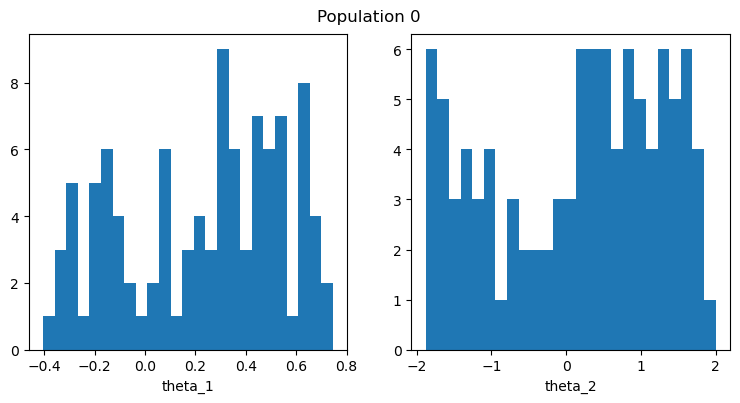

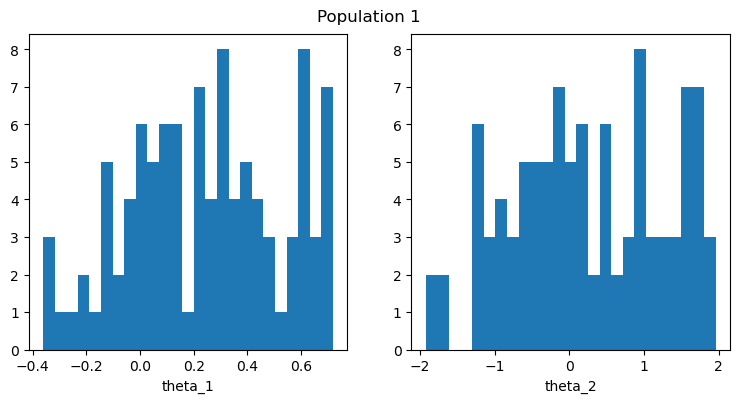

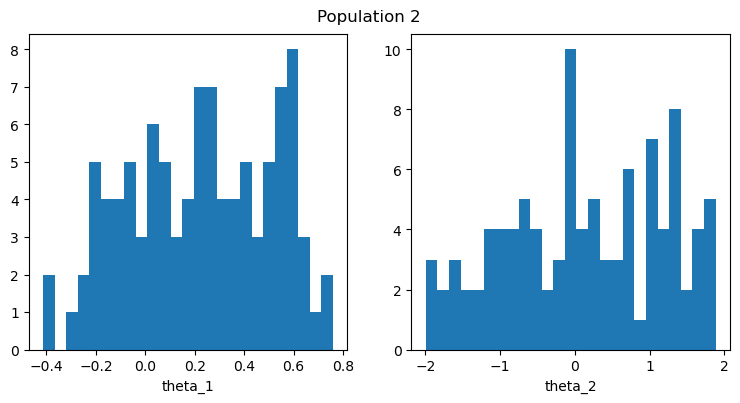

In [35]:
result_smc.plot_marginals(all=True, bins=25, figsize=(8,2), fontsize=12)

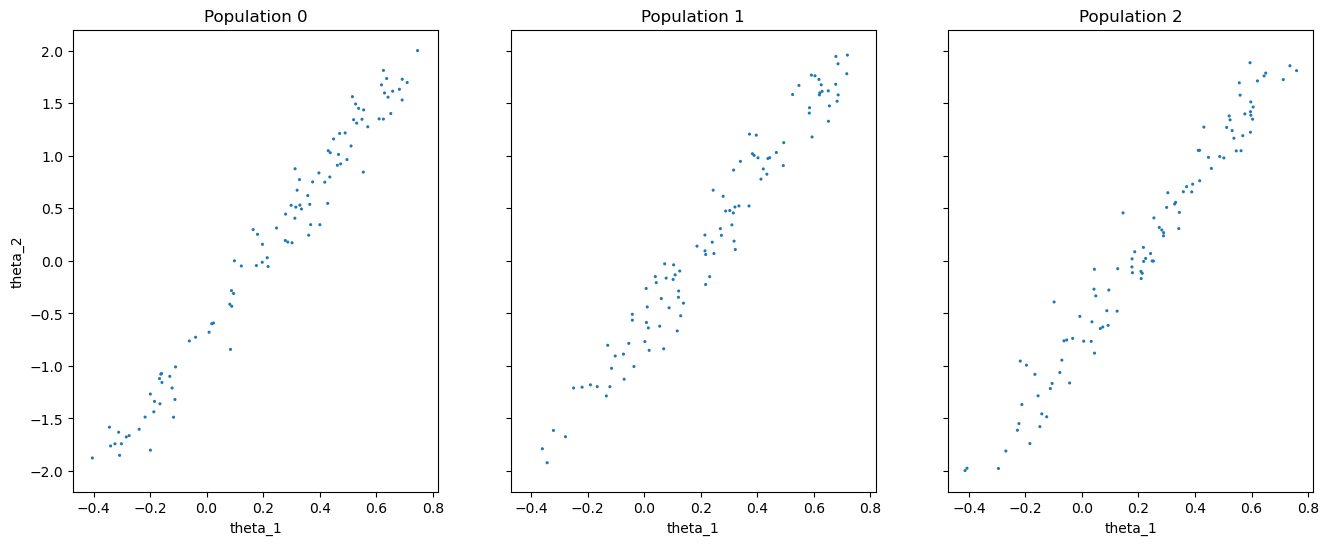

In [36]:
n_populations = len(schedule)
fig, ax = plt.subplots(ncols=n_populations, sharex=True, sharey=True, figsize=(16,6))

for i, pop in enumerate(result_smc.populations):
    s = pop.samples
    ax[i].scatter(s['theta_1'], s['theta_2'], s=5, edgecolor='none');
    ax[i].set_title("Population {}".format(i));
    #ax[i].plot([0, 2, -2, 0], [-1, 1, 1, -1], 'b')
    ax[i].set_xlabel('theta_1');
ax[0].set_ylabel('theta_2');
#ax[0].set_xlim([-2, 2])
#ax[0].set_ylim([-1, 1]);

## OMC

In [15]:
import numpy as np
from sbi.simulators import prior, simulator_omc
from sbi.models.omc import OMCInference

ModuleNotFoundError: No module named 'simulators'

In [4]:
# Define the dimensions and number of samples
N=10000
theta_dim, u_dim = 5, 5 # Dimensions of theta, # Dimension of nuisance variables

# Observation
y_obs = np.full(theta_dim, 0.3) # Assuming y has the same dimension as simulator output
np.random.seed(42)

# Fixed x from a uniform distribution
x_fixed = np.random.uniform(-1,1, theta_dim)

# Sampling thetas from the prior
theta_pr = prior(N, theta_dim)

# Run Inference 
omc_inference = OMCInference(theta_pr, y_obs, x_fixed, u_dim)
samples_pos, weights = omc_inference.infer()
print(f"The number of samples is: {samples_pos.shape[0]}")

# Calculate weighted mean and std for each dimnensioin of theta
weighted_mean = np.average(samples_pos, weights = weights, axis=0)
weighted_variance = np.average((samples_pos - weighted_mean)**2, weights = weights, axis=0)
weighted_std = np.sqrt(weighted_variance)

print(f"The mean value of the posterior distribution is: {weighted_mean}")
print(f"The standard deviation of the posterior distribution is: {weighted_std}")

The number of samples is: 10000
The mean value of the posterior distribution is: [ 0.00538229 -0.02723251 -0.00138771  0.01190336 -0.01144511]
The standard deviation of the posterior distribution is: [1.15842172 1.15358599 1.15297844 1.15212796 1.15044569]


In [5]:
weights.shape

(10000,)

In [7]:
y_obs

array([0.3, 0.3, 0.3, 0.3, 0.3])

In [9]:
theta_pr.shape

(10000, 5)

In [10]:
non_zero_mask = weights>0
filtered_samples = samples_pos[non_zero_mask]
filtered_weights = weights[non_zero_mask]
print(f"The number of the non-negative samples are: {filtered_samples.shape}")

The number of the non-negative samples are: (10000, 5)
